In [1]:
import pandas as pd
import numpy as np
import os, gc, math, sys, re
import os,sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import *
from geopy.distance import vincenty
from datetime import datetime as dt
from datetime import datetime, timedelta
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.cluster import KMeans
import time
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import tabulate as t
import holidays as h

Data fields

- PID - patient ID (unique for each patient)
- EID - exam ID (unique for each patient visit)
- Modality - scanner name (MR1 or MR2)
- Exam - exam name (abbreviated). Corresponds to a particular type of scaning (exam)
- Scheduled - time when the exam was scheduled
- Arrive - time when the patient arrived for this exam
- Begin, Complete - time when exam started/ended
- Scan start - time when scanner started scanning (should be after Begin, but before Complete)
- In PACS - time when the exam was sent to the hospital PACS (Picture Archiving and Communication System) - digital archive of medical images.

Datetime format: MM/DD/YY HH:MM

Scheduled, Arrive, Begin and Complete timestamps are entered manually and may contain errors.



In [13]:
df_ = pd.read_excel('MRIDataOneYear.xlsx')

In [14]:
df_.head(3)

,PID,EID,Modality,Exam,Scheduled,Arrive,Begin,Scan start,Complete,In PACS
0,3406937,24849519,MR2,MRISPECT,2014-04-07 07:45:00,2014-04-07 06:48:00,2014-04-07 07:15:00,2014-04-07 07:15:00,2014-04-07 08:27:00,2014-04-07 08:27:00
1,4171966,24144614,MR1,MRILIVWWO,2014-04-07 07:45:00,2014-04-07 07:04:00,2014-04-07 07:48:00,2014-04-07 07:48:00,2014-04-07 08:39:00,2014-04-07 08:39:00
2,6169209,24855775,MR2,MRISHDW,2014-04-07 08:10:00,2014-04-07 07:46:00,2014-04-07 08:33:00,2014-04-07 08:33:00,2014-04-07 09:17:00,2014-04-07 09:17:00


- очень странно, почему все секунды обрезаны? это дата в Excel или особенности HIS?

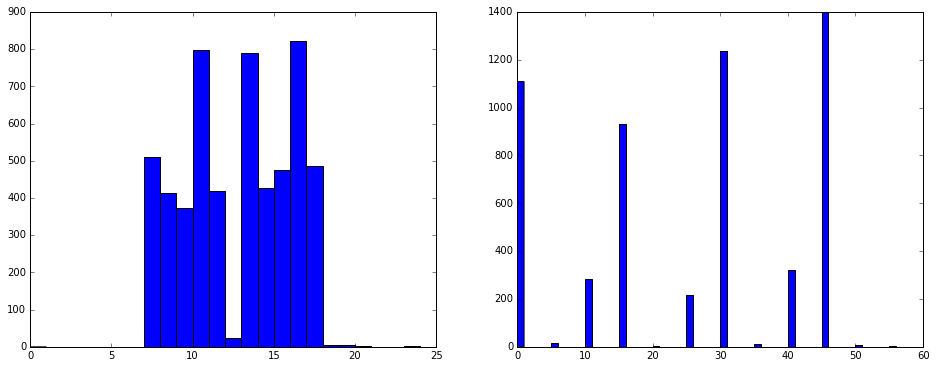

In [5]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Scheduled)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Scheduled)),bins = 60,range = [0,60])

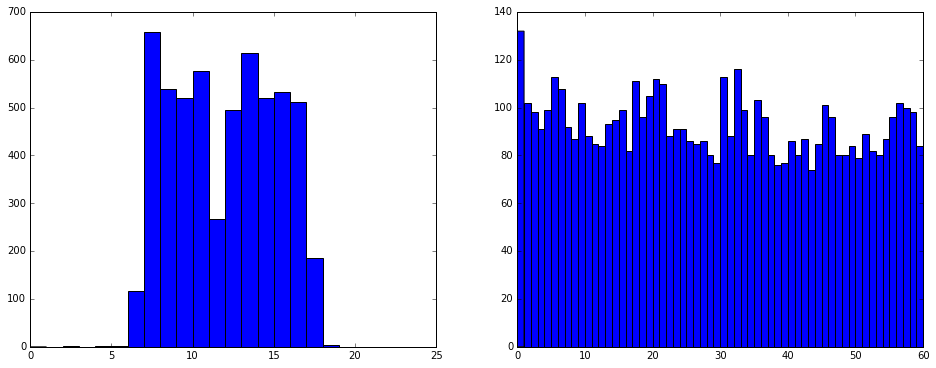

In [6]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Arrive)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Arrive)),bins = 60,range = [0,60])

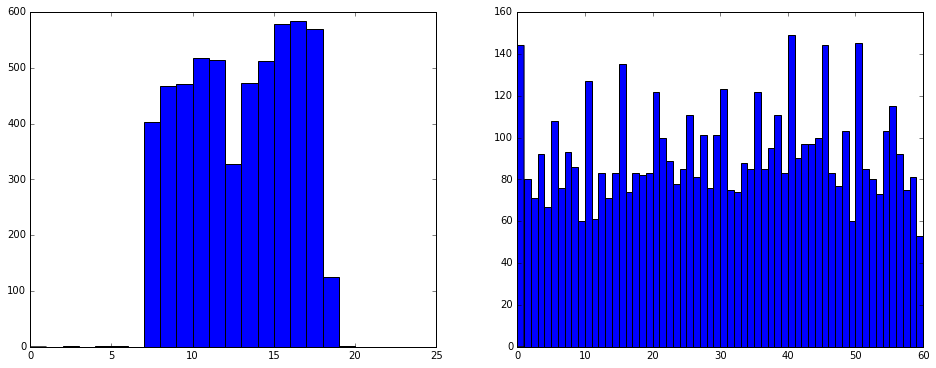

In [7]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Begin)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Begin)),bins = 60,range = [0,60])

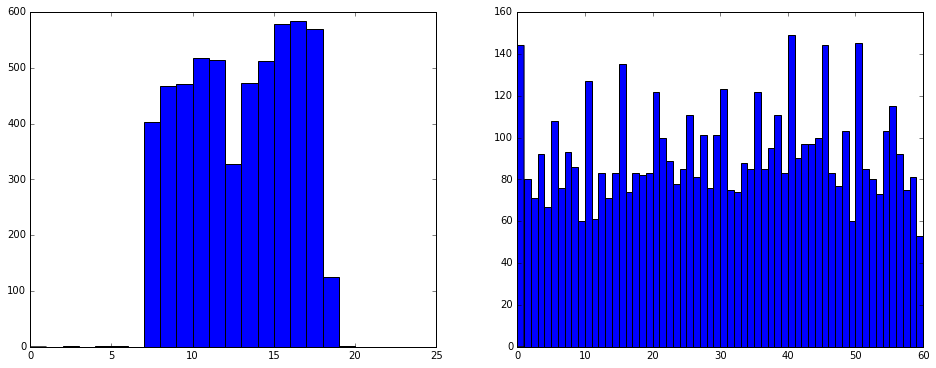

In [8]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['Scan start'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['Scan start'])),bins = 60,range = [0,60])

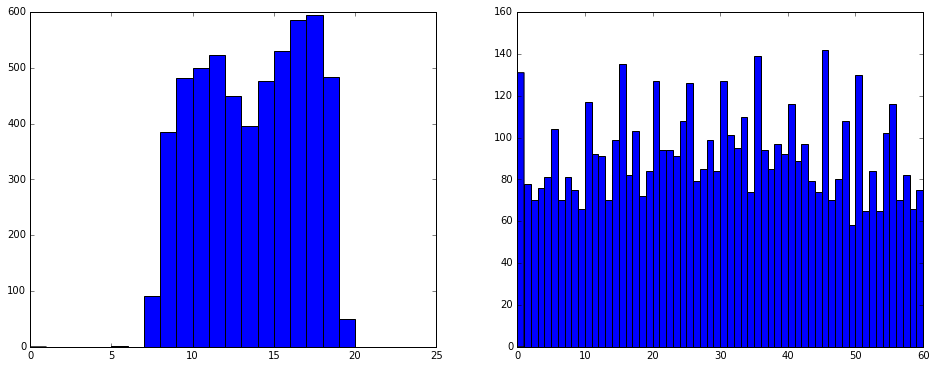

In [9]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df.Complete)),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df.Complete)),bins = 60,range = [0,60])

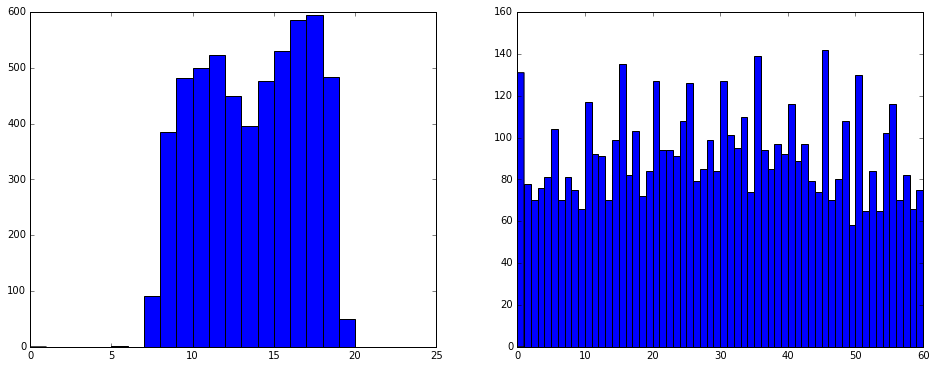

In [10]:
plt.figure(figsize=[16,6])
plt.subplot(121)
a = plt.hist(list(map(lambda x: x.hour, df['In PACS'])),bins = 24,range = [0,24],)
plt.subplot(122)
a = plt.hist(list(map(lambda x: x.minute, df['In PACS'])),bins = 60,range = [0,60])

In [11]:
sum(df['Begin'] > df['Scan start'])

0

In [12]:
sum(df['Scan start'] > df['Complete'])

0

# В этом блоке я буду реализовывать функции для вытягивания фичей

In [13]:
unix_date = datetime(2010, 1, 1,0,0,0)
td = timedelta(seconds=1)
for i in ['Scheduled', 'Arrive', 'Begin','Scan start', 'Complete', 'In PACS']:
    df[i+'_UNIX'] = list(map(lambda x: (x - unix_date) /  td, df[i]))

In [116]:
day = datetime.strptime('02.10.10','%d.%m.%y') - datetime.strptime('01.10.10','%d.%m.%y')
week = datetime.strptime('17.10.10 10:10:10','%d.%m.%y %H:%M:%S') - datetime.strptime('10.10.10 10:10:10','%d.%m.%y %H:%M:%S')
month = datetime.strptime('01.10.10','%d.%m.%y') - datetime.strptime('01.09.10','%d.%m.%y')

In [15]:
# время ожидания от прихода

# TARGET

def time_of_expected(df):
    df['time_of_expected'] = df.Begin - df.Arrive
    df['time_of_expected'] = list(map(lambda x: x.delta/1000000000,df['time_of_expected']))
    return df

In [16]:
datetime.strptime('02.10.10','%d.%m.%y').month

10

In [17]:
# дамми на месяц
df['month'] = list(map(lambda x: x.month, df.Arrive))

In [16]:
# добавить дамми на день недели

df['day_of_week'] = list(map(lambda x: datetime.weekday(x), df.Arrive))

# изменить года для нового датасета
us_hol = h.US(state='MA', years=[2013,2014,2015])
# добавить расстояние до ближайщего справа праздника
def right(x, hol = us_hol):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.min(pd.Series(days)[pd.Series(days) >= 0])
    return day
df['right_holiday'] = list(map(lambda x: right(x), tqdm(df.Arrive)))
# добавить расстояние до ближайщего слева праздника
def left(x):
    days = []
    for i in us_hol:
        days.append((datetime.date(x)-i).days)
    day = np.max(pd.Series(days)[pd.Series(days) <= 0])
    return day
df['left_holiday'] = list(map(lambda x: left(x), tqdm(df.Arrive)))
                          
df['is_holiday'] = list(map(lambda x: int(x in us_hol), df.Arrive))

100%|██████████| 5546/5546 [00:06<00:00, 910.94it/s]


In [108]:
def mape(y_true, y_pred):
    x = list(filter(lambda x: x[0] != 0, zip(y_true, y_pred)))
    y_true = [i[0] for i in x]
    y_pred = [i[1] for i in x]
    #y_true, y_pred = check_array(y_true, y_pred)
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((pd.Series(y_true) - pd.Series(y_pred))) / pd.Series(y_true)) * 100
def quality(true,pred):
    res_df = pd.DataFrame()
    res_df['true'] = true
    res_df['pred'] = pred
    res_df['t-p'] = res_df['true'] - res_df['pred']
    res_df['t-p'] = list(map(lambda x: abs(x), res_df['t-p']))
    res_df = res_df[res_df['true'] != 0]
    return np.mean(res_df['t-p'])/np.mean(res_df['true'])

In [109]:
# время ожидание от запланированного приема (может быть отрицательным)

def time_of_expected_on_shedule(df):
    df['time_of_expected_on_shedule'] = df.Begin - df.Scheduled
    df['time_of_expected_on_shedule'] = list(map(lambda x: x.delta/1000000000,df['time_of_expected_on_shedule']))
    return df

In [110]:
# сколько выполнялось исследование (может быть оооочень большим)

def time_of_procedure(df):
    df['time_of_procedure'] = df['Complete'] - df['Begin']
    df['time_of_procedure'] = list(map(lambda x: x.delta/1000000000,df['time_of_procedure']))
    return df

In [111]:
# сколько пациентов находилось в очереди за delta секунд

def lq(x,y,delta = 0, df = df):
    return df[(df.Arrive_UNIX < x-delta) & (df.Begin_UNIX > x-delta) & (df.Modality == y)].shape[0]
def len_of_queque(df, delta = 0):
    df['len_of_queque_before_'+str(delta)+'_seconds'] = list(map(lambda x, y: lq(x,y,delta,df) , df.Arrive_UNIX, df.Modality))
    return df

In [112]:
# количество зашедших на исследование за некоторое время

# time_delta в секундах

def come_in(x,df,time_delta):
    return df[(df.Begin_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Begin_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_in(df,time_delta):
    df['count_who_come_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_in(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [113]:
# количество вышедших с исследования за некоторое время

# time_delta в секундах

def come_out(x,df,time_delta):
    return df[(df.Complete_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Complete_UNIX <= (x - unix_date)/td )].shape[0]
def count_who_come_out(df,time_delta):
    df['count_who_come_out_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: come_out(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [114]:
# количество пришедших в госпиталь за некоторое время

# time_delta в секундах

def arrive_in(x,df,time_delta):
    return df[(df.Arrive_UNIX >= ((x - unix_date)/td - time_delta) ) & (df.Arrive_UNIX <= (x - unix_date)/td )].shape[0]

def count_who_arrive_in(df,time_delta):
    df['count_who_arrive_in_previous_'+str(time_delta)+'_seconds'] = list(map(lambda x, y: 
            arrive_in(x,df[df.Modality == y],time_delta) , df.Arrive, df.Modality))
    return df

In [117]:
# среднее время ожидания по всем людям, которые пришли за некоторый промежуток времени

def mean_time(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected)
def mean_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение по всем людям, которые пришли за некоторый промежуток времени

def std_time(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected)
def std_time_of_exp(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [118]:
# среднее время проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def mean_time_2(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_procedure)
def mean_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение проведения исследования по всем людям, которые пришли за некоторый промежуток времени

def std_time_2(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_procedure)
def std_time_of_proced(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_proced_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_2(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [119]:
# среднее время отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def mean_time_3(x,df, period):
    return np.mean(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def mean_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['mean_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: mean_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

# оклонение отклонения от расписания по всем людям, которые пришли за некоторый промежуток времени

def std_time_3(x,df, period):
    return np.std(df[(df.Arrive < x) & (df.Arrive >= x - period)].time_of_expected_on_shedule)
def std_time_of_exp_schel(df,multiply = 1,period = day):
    # period as time in unix
    if period == day:
        name = 'day'
    elif period == week:
        name = 'week'
    else:
        name = 'month'
    df['std_time_of_exp_schel_'+str(multiply)+'_'+name] = list(map(lambda x,y: std_time_3(x,df[df.Modality == y], period*multiply), df.Arrive, df.Modality))
    return df

In [27]:
df = time_of_expected(df)
df = time_of_expected_on_shedule(df)
df = time_of_procedure(df)

In [28]:
for i in tqdm(range(0,150,10)):
    df = len_of_queque(df,i)

100%|██████████| 15/15 [02:43<00:00, 10.86s/it]


In [29]:
for i in tqdm(range(0,150,10)):
    df = count_who_come_in(df,60*i)

100%|██████████| 15/15 [03:34<00:00, 14.39s/it]


In [30]:
for i in tqdm(range(0,150,10)):
    df = count_who_arrive_in(df,60*i)

100%|██████████| 15/15 [03:39<00:00, 14.63s/it]


In [32]:
for i in tqdm(range(1,8)):    
    df = mean_time_of_exp(df,i,day)
    df = std_time_of_exp(df,i,day)
    df = mean_time_of_proced(df,i,day)
    df = std_time_of_proced(df,i,day)
    df = mean_time_of_exp_schel(df,i,day)
    df = std_time_of_exp_schel(df,i,day)

100%|██████████| 7/7 [09:20<00:00, 80.67s/it]


In [120]:
for i in tqdm(range(8,13,2)):    
    df = mean_time_of_exp(df,i,day)
    df = std_time_of_exp(df,i,day)
    df = mean_time_of_proced(df,i,day)
    df = std_time_of_proced(df,i,day)
    df = mean_time_of_exp_schel(df,i,day)
    df = std_time_of_exp_schel(df,i,day)

100%|██████████| 3/3 [05:28<00:00, 109.05s/it]


In [121]:
for i in list(df.columns[22:]):
    df[i] = df[i].fillna(0)

In [42]:
def dummie_train(df, col):
    uniq = df[col].unique()
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df, uniq
def dummie_test(df, col, uniq):
    for i in uniq:
        name = col + '_'+ str(i)
        df.loc[:,name] = df[col] == i
        df.loc[:,name] = df.loc[:,name].astype(int)
    return df

In [39]:
for i in tqdm(['Modality','Exam','day_of_week']):
    df,temp_uniq = dummie_train(df,i)

100%|██████████| 3/3 [00:00<00:00,  4.13it/s]


# Сохраним обновленный датафрэйм в пикл

In [122]:
df.to_pickle('new_dataFrame_15_05_2016_features.pkl')

# !!!!!!!!!!!!!!!!

# Загрузим из пикла

In [3]:
df = pd.read_pickle('new_dataFrame.pkl')

# Выберем фичи для модели

In [139]:
df.columns[230:]

Index(['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'month', 'mean_time_of_exp_8_day',
       'std_time_of_exp_8_day', 'mean_time_of_proced_8_day',
       'std_time_of_proced_8_day', 'mean_time_of_exp_schel_8_day',
       'std_time_of_exp_schel_8_day', 'mean_time_of_exp_10_day',
       'std_time_of_exp_10_day', 'mean_time_of_proced_10_day',
       'std_time_of_proced_10_day', 'mean_time_of_exp_schel_10_day',
       'std_time_of_exp_schel_10_day', 'mean_time_of_exp_12_day',
       'std_time_of_exp_12_day', 'mean_time_of_proced_12_day',
       'std_time_of_proced_12_day', 'mean_time_of_exp_schel_12_day',
       'std_time_of_exp_schel_12_day'],
      dtype='object')

In [140]:
cols = df.columns[17:20] + df.columns[23:111] + df.columns[230:]
cols

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


Index(['Modality_MR2', 'count_who_arrive_in_previous_0_seconds',
       'count_who_arrive_in_previous_1200_seconds',
       'count_who_arrive_in_previous_1800_seconds',
       'count_who_arrive_in_previous_2400_seconds',
       'count_who_arrive_in_previous_3000_seconds',
       'count_who_arrive_in_previous_3600_seconds',
       'count_who_arrive_in_previous_4200_seconds',
       'count_who_arrive_in_previous_4800_seconds',
       'count_who_arrive_in_previous_5400_seconds',
       ...
       'std_time_of_proced_10_day', 'std_time_of_proced_12_day',
       'std_time_of_proced_1_day', 'std_time_of_proced_2_day',
       'std_time_of_proced_3_day', 'std_time_of_proced_4_day',
       'std_time_of_proced_5_day', 'std_time_of_proced_6_day',
       'std_time_of_proced_7_day', 'std_time_of_proced_8_day'],
      dtype='object', length=116)

In [159]:
df.columns[:25]

Index(['PID', 'EID', 'Modality', 'Exam', 'Scheduled', 'Arrive', 'Begin',
       'Scan start', 'Complete', 'In PACS', 'Scheduled_UNIX', 'Arrive_UNIX',
       'Begin_UNIX', 'Scan start_UNIX', 'Complete_UNIX', 'In PACS_UNIX',
       'day_of_week', 'right_holiday', 'left_holiday', 'is_holiday',
       'time_of_expected', 'time_of_expected_on_shedule', 'time_of_procedure',
       'len_of_queque_before_0_seconds', 'len_of_queque_before_10_seconds'],
      dtype='object')

In [160]:
cols = df.columns[17:20] + df.columns[23:111] + df.columns[230:]
target = 'time_of_expected'
target_2 = 'time_of_procedure'

/home/dac/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using '+' to provide set union with Indexes is deprecated, use '|' or .union()
  if __name__ == '__main__':


# Выделим тест и трэйн

In [142]:
print(min(df.Arrive))
print(max(df.Arrive))

2014-04-07 06:48:00
2015-04-10 17:49:00


In [162]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[3:df.shape[0]-2]

#for i in cols:
#    df_temp_ = df_temp.sort_values('time_of_expected')
#    df_temp = df_temp_[3:df.shape[0]-2]

date_threshold = datetime.strptime('15.03.2015','%d.%m.%Y')
train = df_temp[df_temp.Arrive < date_threshold]
test = df_temp[df_temp.Arrive >= date_threshold]
train = train.sort_values('Arrive')
test = test.sort_values('Arrive')

In [163]:
df_temp.shape

(5541, 255)

In [164]:
train.shape

(5080, 255)

In [165]:
test.shape

(461, 255)

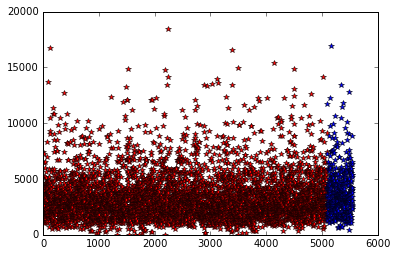

In [166]:
plt.plot(train.time_of_expected,'*r')
plt.plot(test.time_of_expected,'*b')

# Модели

In [167]:
import sklearn.tree as tree
import sklearn.cross_validation as cv

In [168]:
import sklearn.linear_model as lin

In [169]:
import sklearn.ensemble as ens

In [170]:
model = ens.GradientBoostingRegressor()

In [171]:
model = lin.ARDRegression()

# Линейная регрессия

quality-pianyh  0.25600716021024156
mape  28.592813319327565


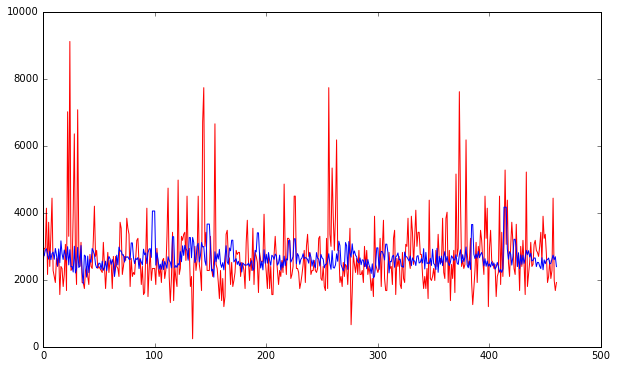

In [172]:
model = lin.LinearRegression()
model.fit(train[cols],train[target_2].values)
res = model.predict(test[cols])
print('quality-pianyh ',quality(test[target_2].values, res))
print('mape ',mape(list(test[target_2].values), list(res)))
plt.figure(figsize=[10,6])
plt.plot(test[target_2].values,'r')
plt.plot(res,'b')

In [173]:
coef = model.coef_
coef_pred = {i:j for (i,j) in zip(cols,coef)}

In [174]:
cols_soso = []
for (i,j) in zip(cols,coef):
    if np.abs(j) > 200:
        cols_soso.append(i)

quality-pianyh  0.2549867845583498
mape  28.017116317698164


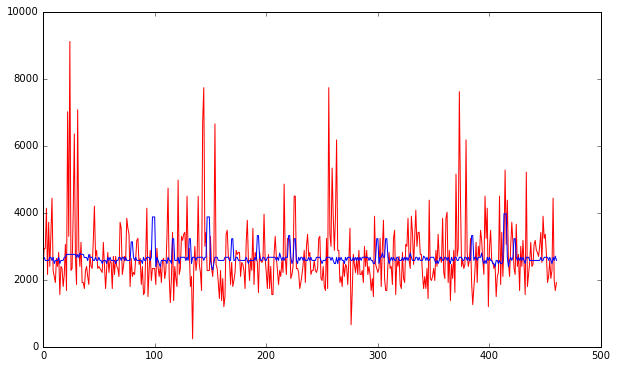

In [176]:
model = lin.LinearRegression()
model.fit(train[cols_soso],train[target_2].values)
res = model.predict(test[cols_soso])
print('quality-pianyh ',quality(test[target_2].values, res))
print('mape ',mape(list(test[target_2].values), list(res)))
plt.figure(figsize=[10,6])
plt.plot(test[target_2].values,'r')
plt.plot(res,'b')

# Байесовская регрессия

In [177]:
from sklearn.linear_model import BayesianRidge, LinearRegression

quality-pianyh  0.35669127077870727
mape  44.17528735613354


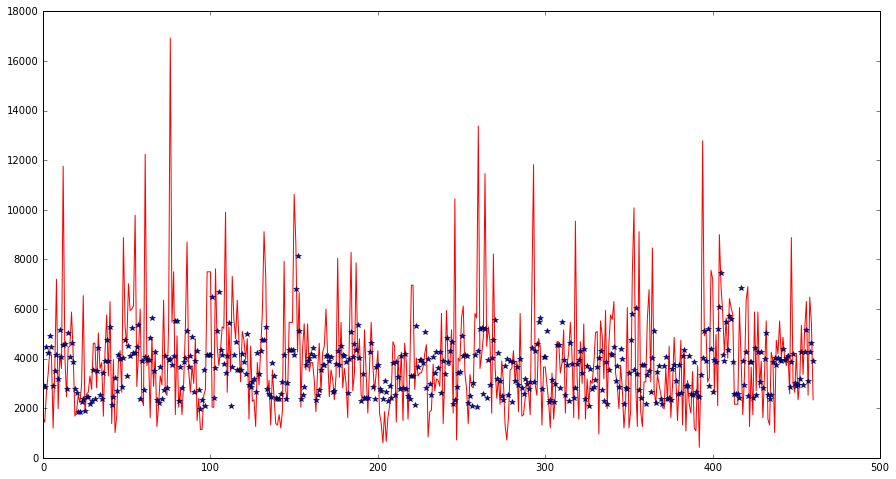

In [184]:
clf = BayesianRidge(n_iter=100, tol=0.00000001, alpha_1=1e-8, alpha_2=1e-10, lambda_1=1e-5, lambda_2=1e8,normalize=True)
clf.fit(train[cols],train[target].values)
res = clf.predict(test[cols])
print('quality-pianyh ',quality(test[target].values, res))
print('mape ',mape(list(test[target].values), list(res)))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(res,'*b')

# Деревья (не показали должного результата)

In [220]:
limits = 11
ress = []
for max_d in range(1,limits):
    model = tree.ExtraTreeRegressor(max_depth=max_d,min_samples_leaf=2,random_state=42,criterion='mse')
    model.fit(train[cols],train[target].values)
    res = model.predict(test[cols])
    ress.append(res.copy())

In [221]:
pred = np.mean(np.array(ress),axis = 0)

quality-pianyh  0.35205654795337454
mape  43.472288749899924


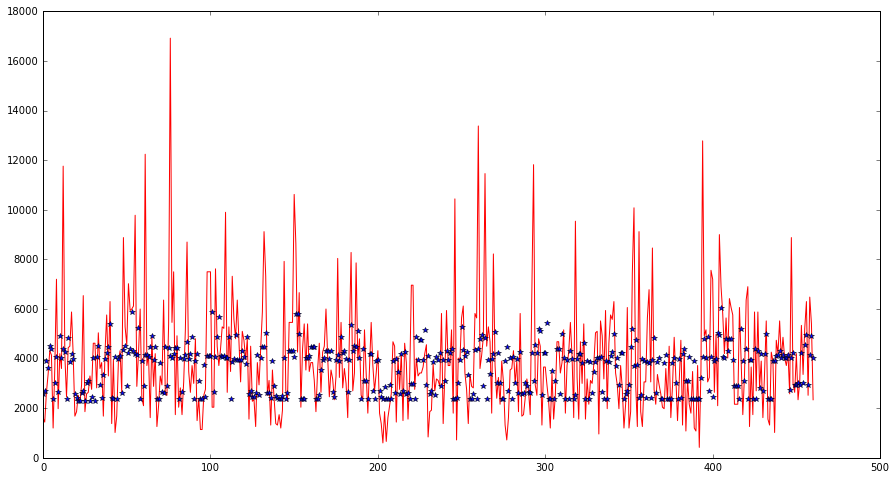

In [222]:
print('quality-pianyh ',quality(test[target].values, pred))
print('mape ',mape(list(test[target].values), list(pred)))
plt.figure(figsize=[15,8])
plt.plot(test[target].values,'-r')
plt.plot(pred,'*b')

In [223]:
import sklearn.metrics as mtr

df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[3:df.shape[0]-1]

lrs = []
ests = []
max_depths = []
qs = []

for learning_rate in tqdm(range(1,301,5)):
    learning_rate = learning_rate / 1000.
    for est in tqdm(list(range(1,10))+list(range(10,100,10))+list(range(100,500,50))+list(range(500,1001,100))):
        strs = []
        for max_depth in list(range(1,10))+list(range(10,50,5))+list(range(50,150,10)):
        #for max_depth in tqdm(list(range(1,10))):
            model = ens.GradientBoostingRegressor(learning_rate = learning_rate,
                                                  n_estimators=est,max_depth=max_depth,random_state=42)
            res = cv.cross_val_predict(model, df_temp[cols],df_temp[target].values,cv = 5,n_jobs=-1)
            q = quality(df_temp[target],res)
            
            qs.append(q)
            lrs.append(learning_rate)
            ests.append(est)
            max_depths.append(max_depth)
            
            strs.append([q,learning_rate,est,max_depth])
            
        d = {'quality':qs,'learning_rate':lrs,'est':ests,'max_depth':max_depths}
        df_result = pd.DataFrame(d)
        df_result.to_csv('result_of_research(GradientBoostingRegressor).csv',index = False)
        #print(t.tabulate(strs))

# Градиентный бустинг

In [224]:
import xgboost as xgb

quality-pianyh  0.349203200826788
mape  42.28900427770995


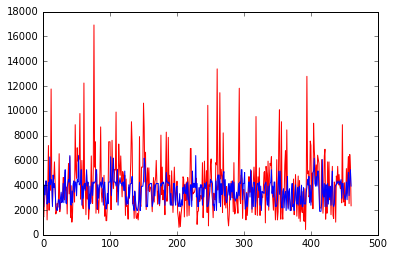

In [251]:
model = xgb.XGBRegressor(max_depth=2,learning_rate=0.7,n_estimators=7,gamma=0.01,reg_alpha=1)
model.fit(train[cols],train[target].values)
res = model.predict(test[cols])
print('quality-pianyh ',quality(test[target].values, res))
print('mape ',mape(list(test[target].values), list(res)))
plt.plot(test[target].values,'r')
plt.plot(res,'b')

# Neural Network

import theano
import theano.tensor as T

rng = np.random
N = train.shape[0]
#Количество столбцов
feats = len(cols)
#Количество тренировочных шагов
training_steps = 10000

# Декларируем символьные переменные Theano 
x = T.matrix("x")
y = T.vector("y")
w = theano.shared(rng.randn(feats), name="w")
b = theano.shared(0., name="b")

X = train[cols]
Y = train[target].values
min_ = min(Y)
max_ = max(Y)
Y = (Y-min_)/(max_-min_)

# Создаем «выражение» Theano
p_1 = 1 / (1 + T.exp(-T.dot(x, w) - b))           # Вероятность того, что результат равен  1
prediction = p_1                                   # Порог для прогнозирования
xent = -y * T.log(p_1) - (1-y) * T.log(1-p_1) # Функция ошибки для перекрестной энтропии
cost = xent.mean() + 0.01 * (w ** 2).sum()  # Стоимость минимизации
gw,gb = T.grad(cost, [w, b])                          # Рассчитываем градиент стоимости
                                          
# Компилируем «выражение» Theano
train_ = theano.function(
          inputs=[x,y],
          outputs=[prediction, xent],
          updates=((w, w - 0.1 * gw), (b, b - 0.1 * gb)))
predict = theano.function(inputs=[x], outputs=prediction)

# Тренировка модели
for i in tqdm(range(training_steps)):
    pred, err = train_(X, Y)

#Прогнозирование
P = predict(test[cols])
#Сохраняем в файл

In [29]:
from pybrain.tools.shortcuts import buildNetwork

In [30]:
net = buildNetwork(len(cols), 10, 1)

In [32]:
net.activate(np.random.random(len(cols)))

array([-2.34529753])

In [135]:
from pybrain.datasets import SupervisedDataSet

In [126]:
def normalization(df, cols):
    df_res = pd.DataFrame()
    df_res['Arrive'] = df.Arrive
    for i in cols:
        temp = (df[i] - min(df[i]))/(max(df[i]) - min(df[i]))
        df_res[i] = temp
    temp = (df['time_of_expected'] - min(df['time_of_expected']))/(max(df['time_of_expected']) - min(df['time_of_expected']))
    df_res['time_of_expected'] = temp
    df_res = df_res.set_index(df.index)
    return df_res

In [127]:
df_temp = df.sort_values('time_of_expected')
df_temp = df_temp[4:df.shape[0]-3]
df_norm = normalization(df_temp,cols)
date_threshold = datetime.strptime('15.03.2015','%d.%m.%Y')
train_norm = df_norm[df_norm.Arrive < date_threshold]
test_norm = df_norm[df_norm.Arrive >= date_threshold]
train_norm = train_norm.sort_values('Arrive')
test_norm = test_norm.sort_values('Arrive')

In [155]:
ds = SupervisedDataSet(len(cols), 1)
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    y = (train_norm.loc[i,target])
    ds.addSample(X,y)

100%|██████████| 5078/5078 [00:05<00:00, 859.73it/s]


In [156]:
len(ds['input'])

5078

In [157]:
import pybrain.supervised.trainers as trn

In [158]:
trainer = trn.BackpropTrainer(net, ds,learningrate=0.05)

In [159]:
err = trainer.trainUntilConvergence(maxEpochs=1000, verbose = 100)

('train-errors:', '[0.008357 , 0.00838  , 0.008397 , 0.008324 , 0.008326 , 0.008353 , 0.008341 , 0.008319 , 0.008399 , 0.008459 , 0.008388 , 0.008387 , 0.008371 , 0.008436 , 0.008358 , 0.008373 , 0.008361 , 0.008269 , 0.008388 , 0.008364 , 0.008366 , 0.008387 , 0.008399 , 0.008443 , 0.008286 , 0.008297 , 0.008402 , 0.008337 , 0.008336 , 0.008384 , 0.008343 , 0.008214 , 0.008362 , 0.0083   , 0.00834  , 0.008305 , 0.008427 , 0.008305 , 0.008339 , 0.008398 , 0.008353 , 0.008227 , 0.008214 , 0.008345 , 0.00831  , 0.008336 , 0.008358 , 0.008425 , 0.008351 , 0.008325 , 0.008331 , 0.008436 , 0.008341 , 0.008318 , 0.008333 , 0.008378 , 0.008489 , 0.008383 , 0.008387 , 0.008417 , 0.00841  , 0.008313 , 0.008256 , 0.008331 , 0.008353 , 0.008415 , 0.008384 , 0.008355 , 0.008431 , 0.008347 , 0.008342 , 0.008452 , 0.008429 , 0.008396 , 0.00837  , 0.008359 , 0.008304 , 0.00837  , 0.008385 , 0.008302 , 0.00841  , 0.008408 , 0.008372 , 0.008305 , 0.008351 , 0.008347 , 0.008398 , 0.008324 , 0.008368 , 0

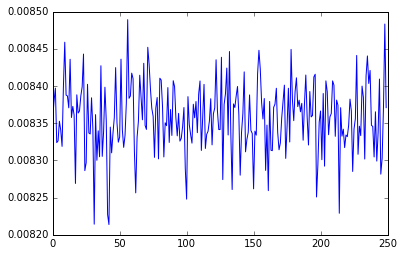

In [165]:
plt.plot(err[0])

100%|██████████| 5078/5078 [00:04<00:00, 1089.85it/s]


quality-pianyh  0.4391585769546855
mape  67.71748168605271


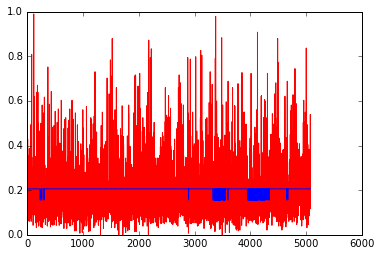

In [166]:
res = []
for i in tqdm(train_norm.index):
    X = list(train_norm.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(train_norm[target].values, res))
print('mape ',mape(list(train_norm[target].values), list(res)))
plt.plot(train_norm[target].values,'r')
plt.plot(res,'b')

100%|██████████| 461/461 [00:00<00:00, 861.64it/s]


quality-pianyh  0.41010003465756445
mape  51.652797199201416


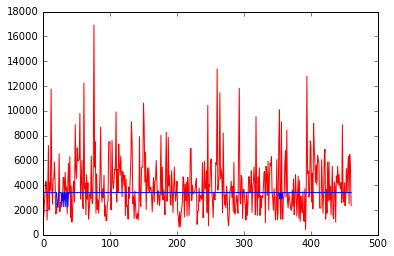

In [72]:
res = []
for i in tqdm(test.index):
    X = list(test.loc[i,cols].values)
    res.append(net.activate(X)[0])
print('quality-pianyh ',quality(test[target].values, res))
print('mape ',mape(list(test[target].values), list(res)))
plt.plot(test[target].values,'r')
plt.plot(res,'b')

# END of Networks

# Смотрю штуки всякие

- без аутлаеров (более 10 тысяч секунд на процедуру) получает вполне себе такая симпатичная диаграммка

In [ ]:
temp = df['time_of_procedure']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(temp[:-3],bins = 30)

In [ ]:
a = plt.hist(df.len_of_queque, bins = 5)

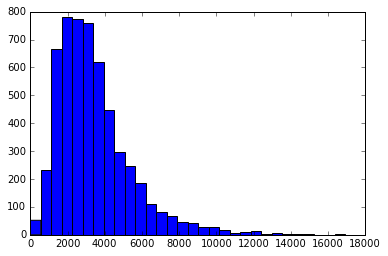

In [96]:
temp = df['time_of_expected']
temp = temp.sort_values()
temp = list(temp)
a = plt.hist(temp[3:-3],bins = 30)

# Estimate result

# Ideas

1. Предсказывать для каждого прихода время ожидания + время проведения исследования и использовать это как фичи
2. Брать среднее от линейной регрессии и какого нибудь бустинга